Jin Jeon

HCDE 530 Computational Concepts

## Project 1b: GoogleSheets API and Data Analysis

### Introduction

#### Using Google Cloud Platform and its API : 
**Google Cloud Platform** is a suite of cloud computing services that lets developers interact with APIs that involve data storage, data analytics, and machine learning. In this notebook, I use GoogleSheets API to directly read in sheets from the drive. Besides reading in the sheets, the API allows you to create, manipulate, filter, and organize metadata. 

With GoogleSheets API, I study survey data collected from my previous projects in user research. The process involves establishing credentials and keys so the program knows to use my credentials to access the private files. 


#### Goal of this notebook: 

Survey studies are essential for understanding the users because they can be quickly developed and sent out to receive a good amount of sample in a short period of time. Surveys are powerful to be utilized for conducting initial research at a discovery stage to explore the general problem space and user behaviors. 

One of the free and efficient tools is the Google Forms. With GoogleSheets API, we are able to access and manipulate incoming or completed data through code. Furthermore, we can easily shape and analyze data through Python. 

While Google Form is capable of generating pie graphs and bar graphs to summarize the survey results, the visualizations are often rudimentary or basic. Using Python, we can easily handle large sets of data and breakdown and analyze the data by each demographic group, and probe for any interesting results.

**Specifically, let's see if there are any significant differences or responses that are made for each age group and gender.**

## Setting up Google Sheets API

The high level process of setting up Google API is as follows: 

**1. Create an Oauth credential** (Instruction link: https://developers.google.com/workspace/guides/create-credentials)


**2. Pip install the required packages** 

> ` pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib` 

**3. Set scope and spreadsheet ID**

 - **Auth scopes** set the permissions that your code requests to authorize for the app
For example, scope code of:
    - **.readonly** allows to read all resources and the meta data but with no writing operations
    - **.label** lets you create, read, update, and delete labels. 

- **Spreadsheet ID** is the parameter that gets used to tell which spreadsheet to access. The ID is called from a part of the full URL.

## Code Implementation

Please note that the following code will only run if you have your Google `credential.json` and `token.json` within the working directory. 

In [1]:
from __future__ import print_function
import os.path
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials

SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']
SPREADSHEET_ID = '11Den6g5nuR4B2CCUML1KrA0bEZXRpPZ7t83Ieyi7NJ4'

# Specify which sheet or row/column of data to call in
# refer to https://developers.google.com/sheets/api/guides/concepts#a1_notation for detail
RANGE_NAME = 'health_data'

creds = Credentials.from_authorized_user_file('token.json', SCOPES)
service = build('sheets', 'v4', credentials=creds)

# Call the Sheets API to read in the data
sheet = service.spreadsheets()
result = sheet.values().get(spreadsheetId = SPREADSHEET_ID,
                            range = RANGE_NAME).execute()
values = result.get('values', [])

**We now have the sheet successfully loaded without having to open the Google Drive at all. We can use the data on the fly. Below, we will just confirm the data type that the data was read in.** 

In [2]:
print(type(result))
print(type(values))

<class 'dict'>
<class 'list'>


**Now let's convert it into a pandas dataframe so we can easily manipuate the data.**

In [3]:
import pandas as pd

data = pd.DataFrame(values[1:], columns=values[0])

# let's confirm 
print(type(data))

data.shape

<class 'pandas.core.frame.DataFrame'>


(71, 27)

## Dataset
From the code above, we translated the data into pandas dataframe. Using `data.shape`, we know that there are total 27 questions collected from 71 participants. For simplicity, I remove any data that does not prefer to disclose gender. This brings the data size to 68. Due to the extensive length and branching logic within the survey, the data becomes more textual and qualitative for questions or columns in the back. I will primarily use selected columns that are of interest. 

Let's have a quick glance at the dataset. 

In [4]:
# for simplicity, let's constrain the gender option to only two
gender_options = ['Man', 'Woman']
data = data[data['What is your gender?'].isin(gender_options)]

print('There are total ' + str(len(data)) + ' participants.')
print('The survey consists of ' + str(data.shape[1]) + ' questions (columns in the dataframe).')

data.head(3)

# convert the column string values to integers
data['How would you rate your health?'] = data['How would you rate your health?'].astype(int)

There are total 69 participants.
The survey consists of 27 questions (columns in the dataframe).


## Data Analysis
Now that we have seen the general dataframe structure, let's explore probing the data for analysis. 

In [5]:
import os
import pandas as pd
from collections import Counter
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import warnings
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import scipy
from tabulate import tabulate

warnings.simplefilter(action='ignore', category=FutureWarning)  # suppress any warning
sns.set_color_codes('pastel')  # set color

### Querying data
Before we play around with data, let's query out the data that are of interest. This way we can manipulate the data more effectively without having to call on the entire dataset `data` everytime. 

There are total 7 different age groups. 

In [6]:
# let's divde the data by gender first 
females = data.loc[data['What is your gender?'] == 'Woman']
males = data.loc[data['What is your gender?'] == 'Man']

# let's also create dataset divided by age group
age_under18 = data.loc[data['What age range are you?'] == 'Under 18']
age_18to24 = data.loc[data['What age range are you?'] == '18 - 24']
age_25to34 = data.loc[data['What age range are you?'] == '25 - 34']
age_35to44 = data.loc[data['What age range are you?'] == '35 - 44']
age_45to54 = data.loc[data['What age range are you?'] == '45 - 54']
age_55to64 = data.loc[data['What age range are you?'] == '55 - 64']
age_over65 = data.loc[data['What age range are you?'] == '65 or older']

## Research Question: How does self-perception of health rating differ by gender and age?

Participants were asked, How would you rate your health? (5 being healthy, 1 being not healthy).

### A. Health rating by gender
Let's breakdown the data to see how self-perception of health wellness varies by gender and different age groups. In the code below, I first quary females and males from the data.

In [7]:
# columns[4] is the column for health rating
mean_males = np.mean(males[males.columns[4]])
mean_females = np.mean(females[females.columns[4]])

print("Mean of males' self-health wellness: " + str(mean_males))
print("Mean of females' self-health wellness: " + str(mean_females))

Mean of males' self-health wellness: 3.5161290322580645
Mean of females' self-health wellness: 3.4473684210526314


### B. Health rating by age group

Now let's breakdown the data to see how self-perception of health wellness varies by different age groups.

In [8]:
age = data.groupby('What age range are you?')['How would you rate your health?'].mean()
age

What age range are you?
18 - 24        3.615385
25 - 34        3.285714
35 - 44        3.500000
45 - 54        3.375000
55 - 64        3.600000
65 or older    4.000000
Under 18       3.000000
Name: How would you rate your health?, dtype: float64

**Conversely, the age group 65 or older actually has the highest self-perception of wellness. The youngest group (age under 18) rated the lowest.**

### C. T-test for statistical signifcance
**However, with small samples of the two demographic groups `65 or older` and `Under 18`, we are not sure if the difference we see here is significant. Let's run a quick t-test to see if the difference we are seeing is statistically significant.** 

In [9]:
t, p = scipy.stats.ttest_ind(age_over65['How would you rate your health?'], age_under18['How would you rate your health?'])

print('t: ' + str(t.round(4)))  
print('p: ' + str(p.round(4)))  # the p-val should be less than 0.05 in general to assume the difference we observe is signifcant

t: 2.8983
p: 0.0199


We see the p-value is 0.01 which is signifcant, which is one interesting find! So we can say that within this dataset, the people age over 65 perceive themselves to be more healthy than teenagers would do. 

### D. Health rating by age & gender group

Now let's breakdown by both gender and different age groups to look at how the self perception of health wellness change.

In [10]:
age_gender = data.groupby(['What age range are you?', 'What is your gender?'])['How would you rate your health?'].mean()

age_gender

What age range are you?  What is your gender?
18 - 24                  Man                     3.428571
                         Woman                   3.833333
25 - 34                  Man                     3.428571
                         Woman                   3.214286
35 - 44                  Man                     3.800000
                         Woman                   3.285714
45 - 54                  Man                     3.400000
                         Woman                   3.333333
55 - 64                  Man                     3.333333
                         Woman                   4.000000
65 or older              Man                     4.000000
                         Woman                   4.000000
Under 18                 Man                     3.000000
                         Woman                   3.000000
Name: How would you rate your health?, dtype: float64

### E. Iteratively running t-test within each age group
We have several different age groups with each male and female gender group. Within each age group, let's run a t-test to see if there are any significant observed differences. 

In [11]:
gender_options = ['Man', 'Woman']
age_groups = ['age_under18', 'age_18to24', 'age_25to34', 'age_35to44', 'age_45to54', 'age_55to64', 'age_over65']

table = []
table.append(['age group', 't value', 'p value'])

# iteratively run for t-tests within each age group defined in the list variable 'age_groups'
for i in range(0, len(age_groups)):
    data_string = "['How would you rate your health?']"
    eval_string1 = age_groups[i] + '.loc[' + age_groups[i] + "['What is your gender?'] == 'Man']"
    a = eval(eval_string1 + data_string)
    eval_string2 = age_groups[i] + '.loc[' + age_groups[i] + "['What is your gender?'] == 'Woman']"
    b = eval(eval_string2 + data_string)
    strings_combined = 'scipy.stats.ttest_ind(a, b)'

#     print(strings_combined)
    t, p = eval(strings_combined)
    
    # we use a package called tabulate to print out a formatted table
    table.append([age_groups[i], t.round(4) ,p.round(4)])

print(tabulate(table, headers='firstrow'))

age group      t value    p value
-----------  ---------  ---------
age_under18   nan        nan
age_18to24     -1.1315     0.2819
age_25to34      0.4504     0.6575
age_35to44      0.9682     0.3558
age_45to54      0.1637     0.8754
age_55to64     -0.7746     0.495
age_over65      0          1


/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


**We see that the p-values are all above 0.05 which means that there are no observed significant differences in gender within each age group.**

## Data Visualization

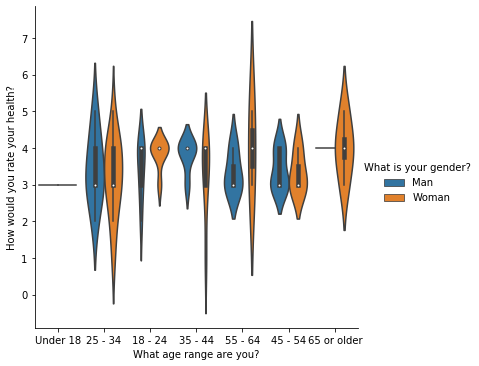

In [12]:
age_plot = sns.catplot(x='What age range are you?', y='How would you rate your health?', \
                       hue='What is your gender?', kind="violin", data=data);

### References 

GoogleSheets API v4: https://developers.google.com/sheets/api/samples/reading

Google Oauth: https://developers.google.com/identity/protocols/oauth2/service-account#python

Google API Python Client: https://github.com/googleapis/google-api-python-client/blob/master/docs/oauth.md

Credentials: https://developers.google.com/workspace/guides/create-credentials
